# Malicious URL CLassification

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import hex2color
from gensim.models import Word2Vec
from nltk import ngrams
import re

## Import the dataset

In [38]:
DATASET_FILE = "./datasets/malicious_phish.csv"

df = pd.read_csv(DATASET_FILE)

df.rename(columns={"type": "target"}, inplace=True)

In [39]:
df["target"].value_counts()

benign        428103
defacement     96457
phishing       94111
malware        32520
Name: target, dtype: int64

# Rename target values

In [40]:
df['target'] = df['target'].map(lambda x: 'malicious' if x != 'benign' else 'benign')

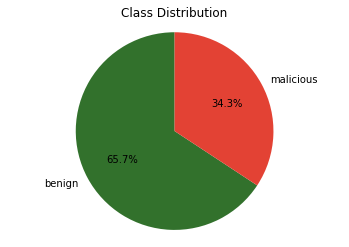

In [41]:
distribution = dict(df["target"].value_counts())

# Set up the figure with a white background
fig, ax = plt.subplots(facecolor='white')

dull_red = hex2color('#E34234')
dull_green = hex2color('#32712C')

# Plotting the pie chart
ax.pie(distribution.values(), labels=distribution.keys(), colors=[dull_green, dull_red], autopct='%1.1f%%', startangle=90)
ax.set_title('Class Distribution')
ax.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.

# Show the pie chart
plt.show()

## URL Tokenization and Word Embedding with Word2Vec

In [91]:
def preprocess_url(url):
    # Remove sequential strings following '#' and '?'
    url = re.sub(r"#.*", "", url)
    url = re.sub(r"\?.*", "", url)

    # Split the URL into protocol and rest (domain, path and file)
    protocol, rest = url.split("://", 1) if "://" in url else ("", url)

    # Split the rest into domain and rest (path and file)
    domain, rest = rest.split("/", 1) if "/" in rest else (rest, "")
    
    # Split the rest into path and file
    path, file = rest.rsplit("/", 1) if "/" in rest else (rest, "")

    return [protocol, domain, path, file]



# Token extraction
tokenized_urls = [preprocess_url(url) for url in df['url'].tolist()]

# Train Word2Vec model
model = Word2Vec(sentences=tokenized_urls, vector_size=100, window=5, min_count=1, workers=4)

In [94]:
import numpy as np

# Function to get the aggregated embedding for a URL
def get_url_embedding(url_tokens, model):
    embeddings = [model.wv[token] for token in url_tokens if token in model.wv]
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(model.vector_size)


print(tokenized_urls[:10])

# Generate embeddings for each URL
url_embeddings = [get_url_embedding(url_token, model) for url_token in tokenized_urls]

# Now, url_embeddings is a list of vectors representing each URL
print(url_embeddings[:10])

[['', 'br-icloud.com.br', '', ''], ['', 'mp3raid.com', 'music', 'krizz_kaliko.html'], ['', 'bopsecrets.org', 'rexroth/cr', '1.htm'], ['http', 'www.garage-pirenne.be', 'index.php', ''], ['http', 'adventure-nicaragua.net', 'index.php', ''], ['http', 'buzzfil.net', 'm/show-art', 'ils-etaient-loin-de-s-imaginer-que-le-hibou-allait-faire-ceci-quand-ils-filmaient-2.html'], ['', 'espn.go.com', 'nba/player/_/id/3457', 'brandon-rush'], ['', 'yourbittorrent.com', '', ''], ['http', 'www.pashminaonline.com', 'pure-pashminas', ''], ['', 'allmusic.com', 'album', 'crazy-from-the-heat-r16990']]
[array([ 0.05569348,  0.54655725,  1.113113  ,  1.7397156 , -2.6709473 ,
        0.32509097,  3.7759109 , -1.7954855 ,  1.4673101 , -0.31381333,
        0.8969219 , -0.84895265, -2.5421128 ,  0.17016381, -1.5961785 ,
        0.7433325 , -2.4170187 , -2.3151627 ,  0.20573801,  3.149556  ,
        2.6762347 , -0.52037674,  1.1961789 ,  3.5969024 , -0.96003807,
        1.2940048 , -0.5140866 , -2.1769152 ,  0.0322

In [99]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(url_embeddings, df['target'].tolist(), test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

# Print the basic statistics of the training set
data_counts = {
    "train": pd.Series(y_train).value_counts().to_list(),
    "test": pd.Series(y_test).value_counts().to_list(),
    "validation": pd.Series(y_val).value_counts().to_list(),
    "total": pd.Series(df['target'].tolist()).value_counts().to_list(),
}
print(pd.DataFrame(data_counts, index=["benign", "malicious"]))

            train   test  validation   total
benign     342325  42748       43030  428103
malicious  178627  22371       22090  223088


In [100]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler(copy=True, with_mean=True, with_std=True)

# Fit the scaler on the training data
ss.fit(X_train)

# Transform the training, validation, and testing data
X_train = ss.transform(X_train)
X_test = ss.transform(X_test)
X_val = ss.transform(X_val)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

rf_classifier.fit(X_train, y_train)